In [1]:
# Marco de Evaluación para Contenido Educativo Generado por LLM
# =================================================================
# Este notebook implementa un marco de evaluación automatizada para el contenido educativo
# generado por un agente basado en LLM, incluyendo métricas de relevancia, consistencia,
# legibilidad y uso de terminología especializada.

import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
# Configuración inicial
plt.style.use('ggplot')
np.random.seed(42)

# Cargar el modelo de spaCy para español
def load_spacy_model():
    """
    Carga el modelo de spaCy para español, descargándolo si es necesario
    """
    try:
        nlp = spacy.load("es_core_news_md")
        print("Modelo de spaCy cargado correctamente.")
        return nlp
    except OSError:
        print("Descargando modelo de spaCy...")
        os.system("python -m spacy download es_core_news_md")
        try:
            nlp = spacy.load("es_core_news_md")
            print("Modelo de spaCy descargado y cargado correctamente.")
            return nlp
        except Exception as e:
            print(f"Error al cargar el modelo de spaCy: {e}")
            # Fallback a un modelo más simple
            print("Usando modelo básico como fallback.")
            return spacy.blank("es")

nlp = load_spacy_model()

# Funciones de utilidad para procesamiento de texto
def sent_tokenize(text):
    """Función para dividir el texto en oraciones usando spaCy"""
    if not isinstance(text, str):
        return []
    
    try:
        doc = nlp(text)
        return [sent.text for sent in doc.sents]
    except Exception as e:
        print(f"Error al tokenizar oraciones: {e}")
        # Fallback simple a separación por puntos
        return text.split('. ')

def word_tokenize(text):
    """Función para dividir el texto en palabras usando spaCy"""
    if not isinstance(text, str):
        return []
    
    try:
        doc = nlp(text)
        return [token.text for token in doc if not token.is_space]
    except Exception as e:
        print(f"Error al tokenizar palabras: {e}")
        # Fallback simple a separación por espacios
        return text.split()

def get_stopwords():
    """Obtiene lista de stopwords en español desde spaCy"""
    try:
        return list(nlp.Defaults.stop_words)
    except:
        # Lista básica de stopwords en español como fallback
        return ["el", "la", "los", "las", "un", "una", "unos", "unas", "y", "o", "a", "ante", "bajo", 
                "con", "contra", "de", "desde", "en", "entre", "hacia", "hasta", "para", "por", 
                "según", "sin", "sobre", "tras", "es", "son", "está", "están"]

# Funciones para cargar y validar datos
def load_json_data(json_path):
    if os.path.exists(json_path):
        with open(json_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    return None

def create_sample_data():
    # Crear datos de ejemplo con la estructura correcta
    return {
        "course_name": "Curso de Ejemplo",
        "materials": {
            "Tema 1": {
                "notes": "Notas del tema 1",
                "exercises": "Ejercicios del tema 1"
            },
            "Tema 2": {
                "notes": "Notas del tema 2",
                "exercises": "Ejercicios del tema 2"
            }
        }
    }

def get_content_types(data):
    # Obtiene todos los tipos de contenido presentes en los materiales
    content_types = set()
    
    for tema, contenidos in data["materials"].items():
        if isinstance(contenidos, dict):
            for content_type in contenidos.keys():
                content_types.add(content_type)
    
    return list(content_types)

def extract_domain_keywords(course_name, materials):
    """
    Extrae palabras clave del dominio basadas en el nombre del curso y los materiales.
    """
    if not course_name or not materials:
        return []
        
    # Combinamos todos los textos para análisis
    all_text = course_name + " "
    
    # Para cada tema en los materiales
    for topic, content in materials.items():
        if not isinstance(content, dict):
            continue
            
        all_text += topic + " "
        
        # Para cada tipo de contenido (notes, exercises, etc.)
        for content_type, text in content.items():
            if not isinstance(text, str):
                continue
                
            # Agregamos el texto al análisis
            all_text += text + " "
    
    # Para este ejemplo, simplemente dividimos por palabras y tomamos algunas
    # En un caso real, usaríamos técnicas más sofisticadas como spaCy
    words = all_text.split()
    # Eliminamos duplicados y limitamos a 20 palabras
    domain_keywords = list(set([word.lower() for word in words if len(word) > 3]))[:20]
    
    return domain_keywords

def validate_json_structure(data):
    """
    Valida la estructura básica del JSON para asegurar que contiene los campos necesarios.
    
    Args:
        data (dict): Datos cargados del JSON
        
    Returns:
        bool, str: (es_válido, mensaje_error)
    """
    # Verificar campos obligatorios de primer nivel
    if not isinstance(data, dict):
        return False, "Los datos cargados no son un diccionario JSON válido"
    
    if "course_name" not in data:
        return False, "El JSON no contiene el campo 'course_name'"
    
    if "materials" not in data:
        return False, "El JSON no contiene el campo 'materials'"
    
    if not isinstance(data["materials"], dict) or len(data["materials"]) == 0:
        return False, "El campo 'materials' no es un diccionario válido o está vacío"
    
    # Verificar al menos un tema tiene formato correcto
    tema_valido = False
    for tema, contenidos in data["materials"].items():
        if isinstance(contenidos, dict) and len(contenidos) > 0:
            tema_valido = True
            break
    
    if not tema_valido:
        return False, "No se encontró ningún tema con contenido válido"
    
    return True, "Estructura JSON válida"

# Funciones de evaluación
def evaluate_relevance(text, keywords):
    """
    Calcula la relevancia del texto basado en palabras clave.
    """
    if not isinstance(text, str) or not text.strip() or not keywords:
        return 0
    
    try:
        doc = nlp(text.lower())
        
        # Normaliza las palabras clave (lematización para mejor coincidencia)
        keywords_lemma = []
        for kw in keywords:
            try:
                kw_doc = nlp(kw.lower())
                if len(kw_doc) > 0:
                    keywords_lemma.append(kw_doc[0].lemma_)
                else:
                    keywords_lemma.append(kw.lower())
            except:
                keywords_lemma.append(kw.lower())
        
        # Cuenta coincidencias
        found = 0
        for token in doc:
            if token.lemma_ in keywords_lemma or token.text.lower() in [k.lower() for k in keywords]:
                found += 1
        
        # Normaliza el resultado
        total_tokens = len([t for t in doc if not t.is_punct and not t.is_space])
        relevance_score = found / len(keywords) if keywords and total_tokens > 0 else 0
        
        return min(1.0, relevance_score)  # Máximo 1.0
    except Exception as e:
        print(f"Error al evaluar relevancia: {e}")
        return 0

def evaluate_readability(text):
    """
    Calcula una versión simplificada del índice de legibilidad para español.
    """
    if not isinstance(text, str) or not text.strip():
        return 0
    
    try:
        sentences = sent_tokenize(text)
        if not sentences:
            return 0
            
        words = word_tokenize(text)
        if not words:
            return 0
        
        # Contamos sílabas (aproximación para español)
        def count_syllables(word):
            word = word.lower()
            vowels = "aeiouáéíóúü"
            count = 0
            prev_vowel = False
            
            for char in word:
                is_vowel = char in vowels
                if is_vowel and not prev_vowel:
                    count += 1
                prev_vowel = is_vowel
            
            # Mínimo una sílaba por palabra
            return max(1, count)
        
        # Calcula métricas
        num_sentences = len(sentences)
        num_words = len(words)
        num_syllables = sum(count_syllables(word) for word in words)
        
        # Fórmula simplificada de legibilidad para español
        # Adaptada de la fórmula de Flesch-Szigriszt
        if num_words == 0 or num_sentences == 0:
            return 0
            
        score = 206.835 - (62.3 * (num_syllables / num_words)) - (1.02 * (num_words / num_sentences))
        
        # Normaliza entre 0-100
        return max(0, min(100, score))
    except Exception as e:
        print(f"Error al evaluar legibilidad: {e}")
        return 0

def evaluate_content_relevance(content, keywords, threshold=0.3):
    """
    Evalúa la relevancia del contenido basada en palabras clave del dominio.
    """
    if not isinstance(content, str) or not content.strip() or not keywords:
        return {
            "relevance_score": 0,
            "distribution_score": 0,
            "beginning_score": 0,
            "middle_score": 0,
            "end_score": 0,
            "passes_threshold": False
        }
    
    try:
        # Obtenemos la puntuación de relevancia
        relevance_score = evaluate_relevance(content, keywords)
        
        # Analizamos la distribución de keywords en diferentes partes del texto
        sentences = sent_tokenize(content)
        num_sentences = len(sentences)
        
        if num_sentences < 3:
            return {
                "relevance_score": relevance_score,
                "distribution_score": 1.0,
                "beginning_score": relevance_score,
                "middle_score": relevance_score,
                "end_score": relevance_score,
                "passes_threshold": relevance_score >= threshold
            }
        
        # Dividimos el texto en inicio, medio y fin
        section_size = max(1, num_sentences // 3)
        beginning = " ".join(sentences[:section_size])
        middle = " ".join(sentences[section_size:2*section_size])
        end = " ".join(sentences[2*section_size:])
        
        # Calculamos relevancia en cada sección
        beginning_score = evaluate_relevance(beginning, keywords)
        middle_score = evaluate_relevance(middle, keywords)
        end_score = evaluate_relevance(end, keywords)
        
        # Calculamos distribución
        distribution_scores = [beginning_score, middle_score, end_score]
        distribution_std = np.std(distribution_scores)
        distribution_score = 1.0 - min(1.0, distribution_std * 2)
        
        return {
            "relevance_score": relevance_score,
            "distribution_score": distribution_score,
            "beginning_score": beginning_score,
            "middle_score": middle_score,
            "end_score": end_score,
            "passes_threshold": relevance_score >= threshold,
        }
    except Exception as e:
        print(f"Error al evaluar relevancia de contenido: {e}")
        return {
            "relevance_score": 0,
            "distribution_score": 0,
            "beginning_score": 0,
            "middle_score": 0,
            "end_score": 0,
            "passes_threshold": False
        }

def evaluate_topic_consistency(topic_materials):
    """
    Evalúa la consistencia temática entre diferentes tipos de contenido para un mismo tema.
    """
    if not isinstance(topic_materials, dict) or len(topic_materials) < 2:
        return {"consistency_score": 1.0, "pairwise_similarities": {}}
    
    try:
        content_by_type = {}
        
        # Para cada tipo de contenido (notes, exercises, etc.)
        for content_type, text in topic_materials.items():
            if not isinstance(text, str) or not text.strip():
                continue
                
            # Si el texto es muy largo, tomamos una muestra para el análisis
            if len(text) > 10000:
                # Dividimos en párrafos y tomamos una muestra
                paragraphs = text.split('\n\n')
                # Tomamos los primeros párrafos como muestra representativa
                sample_text = '\n\n'.join(paragraphs[:15])
                content_by_type[content_type] = sample_text
            else:
                content_by_type[content_type] = text
        
        # Si no tenemos suficientes tipos de contenido para comparar
        if len(content_by_type) < 2:
            return {"consistency_score": 1.0, "pairwise_similarities": {}}
        
        # Usamos TF-IDF para vectorizar los textos
        tfidf_vectorizer = TfidfVectorizer(max_features=1000)
        content_types = list(content_by_type.keys())
        texts = [content_by_type[ct] for ct in content_types]
        
        # Transformamos los textos a vectores TF-IDF
        tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
        # Calculamos similitud coseno entre los vectores
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        # Calculamos similitudes por pares
        pairwise_similarities = {}
        sum_similarities = 0
        count_pairs = 0
        
        for i in range(len(content_types)):
            for j in range(i+1, len(content_types)):
                pair_key = f"{content_types[i]}-{content_types[j]}"
                similarity = similarity_matrix[i, j]
                pairwise_similarities[pair_key] = similarity
                sum_similarities += similarity
                count_pairs += 1
        
        if count_pairs == 0:
            return {"consistency_score": 1.0, "pairwise_similarities": {}}
        
        # Calculamos promedio de consistencia
        consistency_score = sum_similarities / count_pairs
        
        return {
            "consistency_score": consistency_score,
            "pairwise_similarities": pairwise_similarities
        }
    except Exception as e:
        print(f"Error al evaluar consistencia: {e}")
        return {"consistency_score": 0.0, "pairwise_similarities": {}}

def evaluate_cross_topic_consistency(materials):
    """
    Evalúa la consistencia entre temas para un mismo tipo de contenido.
    Si solo hay un tema, devuelve una puntuación perfecta.
    """
    if not isinstance(materials, dict) or len(materials) <= 1:
        # Si solo hay un tema, no hay consistencia cruzada que evaluar
        content_types = set()
        if len(materials) == 1:
            for _, contents in materials.items():
                if isinstance(contents, dict):
                    content_types.update(contents.keys())
        
        return {content_type: {"consistency_score": 1.0} for content_type in content_types}
    
    try:
        # Reorganizamos los datos por tipo de contenido
        content_by_type = {}
        for topic, contents in materials.items():
            if not isinstance(contents, dict):
                continue
                
            for content_type, text in contents.items():
                if not isinstance(text, str) or not text.strip():
                    continue
                    
                if content_type not in content_by_type:
                    content_by_type[content_type] = {}
                
                # Si el texto es muy largo, tomamos una muestra para el análisis
                if len(text) > 10000:
                    paragraphs = text.split('\n\n')
                    sample_text = '\n\n'.join(paragraphs[:15])
                    content_by_type[content_type][topic] = sample_text
                else:
                    content_by_type[content_type][topic] = text
        
        # Evaluamos la consistencia para cada tipo de contenido
        cross_topic_results = {}
        
        for content_type, topic_texts in content_by_type.items():
            topics = list(topic_texts.keys())
            texts = [topic_texts[topic] for topic in topics]
            
            # Si no hay suficientes temas para este tipo de contenido, continuamos
            if len(texts) < 2:
                cross_topic_results[content_type] = {"consistency_score": 1.0}
                continue
            
            try:
                tfidf_vectorizer = TfidfVectorizer(max_features=1000)
                tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
                similarity_matrix = cosine_similarity(tfidf_matrix)
                
                # Calculamos similitudes por pares de temas
                pairwise_similarities = {}
                sum_similarities = 0
                count_pairs = 0
                
                for i in range(len(topics)):
                    for j in range(i+1, len(topics)):
                        pair_key = f"{topics[i]}-{topics[j]}"
                        similarity = similarity_matrix[i, j]
                        pairwise_similarities[pair_key] = similarity
                        sum_similarities += similarity
                        count_pairs += 1
                
                if count_pairs == 0:
                    cross_topic_results[content_type] = {"consistency_score": 1.0}
                    continue
                
                # Calculamos la puntuación promedio de consistencia entre temas
                consistency_score = sum_similarities / count_pairs
                
                cross_topic_results[content_type] = {
                    "consistency_score": consistency_score,
                    "pairwise_similarities": pairwise_similarities
                }
            except Exception as e:
                print(f"Error al calcular la consistencia entre temas para {content_type}: {e}")
                cross_topic_results[content_type] = {"consistency_score": 0.0}
        
        return cross_topic_results
    except Exception as e:
        print(f"Error al evaluar consistencia entre temas: {e}")
        return {}

def calculate_readability_metrics(text):
    """
    Calcula métricas de legibilidad para un texto.
    """
    if not isinstance(text, str) or not text.strip():
        return {
            "word_count": 0,
            "flesch_reading_ease": 0,
            "avg_sentence_length": 0,
            "avg_word_length": 0,
            "lexical_density": 0,
            "lexical_diversity": 0
        }
    
    try:
        # Si el texto es muy largo, tomamos una muestra para el análisis
        sample_text = text
        if len(text) > 10000:
            # Dividimos en párrafos y tomamos una muestra representativa
            paragraphs = text.split('\n\n')
            
            # Tomamos párrafos del inicio, medio y final para una muestra representativa
            sample_paragraphs = []
            if len(paragraphs) > 15:
                # Inicio (5 párrafos)
                sample_paragraphs.extend(paragraphs[:5])
                # Medio (5 párrafos)
                mid_idx = len(paragraphs) // 2
                sample_paragraphs.extend(paragraphs[mid_idx-2:mid_idx+3])
                # Final (5 párrafos)
                sample_paragraphs.extend(paragraphs[-5:])
            else:
                sample_paragraphs = paragraphs
                
            sample_text = '\n\n'.join(sample_paragraphs)
        
        # Tokenizamos el texto
        sentences = sent_tokenize(sample_text)
        words = word_tokenize(sample_text)
        
        if not sentences or not words:
            return {
                "word_count": 0,
                "flesch_reading_ease": 0,
                "avg_sentence_length": 0,
                "avg_word_length": 0,
                "lexical_density": 0,
                "lexical_diversity": 0
            }
        
        # Calculamos métricas básicas
        word_count = len(words)
        flesch_reading_ease = evaluate_readability(sample_text)
        avg_sentence_length = word_count / len(sentences)
        avg_word_length = sum(len(w) for w in words) / word_count
        
        # Densidad léxica (palabras de contenido / total palabras)
        stopwords = get_stopwords()
        content_words = [w for w in words if w.lower() not in stopwords]
        lexical_density = len(content_words) / word_count
        
        # Diversidad léxica (palabras únicas / total palabras)
        unique_words = set(w.lower() for w in words if w.isalpha())
        lexical_diversity = len(unique_words) / word_count
        
        return {
            "word_count": word_count,
            "flesch_reading_ease": flesch_reading_ease,
            "avg_sentence_length": avg_sentence_length,
            "avg_word_length": avg_word_length,
            "lexical_density": lexical_density,
            "lexical_diversity": lexical_diversity
        }
    except Exception as e:
        print(f"Error al calcular métricas de legibilidad: {e}")
        return {
            "word_count": 0,
            "flesch_reading_ease": 0,
            "avg_sentence_length": 0,
            "avg_word_length": 0,
            "lexical_density": 0,
            "lexical_diversity": 0
        }

def interpret_readability_score(score):
    """
    Interpreta una puntuación de legibilidad.
    """
    if score >= 90:
        return "Muy fácil de leer"
    elif score >= 80:
        return "Fácil de leer"
    elif score >= 70:
        return "Bastante fácil de leer"
    elif score >= 60:
        return "Lenguaje estándar"
    elif score >= 50:
        return "Moderadamente difícil"
    elif score >= 30:
        return "Difícil de leer"
    else:
        return "Muy difícil de leer"

def analyze_domain_terminology(text, domain_keywords, course_name):
    """
    Analiza el uso de terminología específica del dominio en el texto.
    """
    if not isinstance(text, str) or not text.strip() or not domain_keywords:
        return {
            "terminology_density": 0,
            "domain_term_count": 0,
            "total_words": 0,
            "unique_terms_used": 0,
            "most_common_terms": [],
            "definitions_found": [],
            "term_consistency": {},
            "terminology_score": 0
        }
    
    try:
        # Si el texto es muy largo, procesamos por partes
        if len(text) > 15000:
            # Dividimos el texto en secciones más pequeñas
            chunks = []
            chunk_size = 10000
            for i in range(0, len(text), chunk_size):
                chunks.append(text[i:i+chunk_size])
            
            # Procesamos cada chunk con spaCy
            term_counter = Counter()
            total_words = 0
            
            for chunk in chunks:
                chunk_doc = nlp(chunk)
                
                # Contamos términos del dominio
                for token in chunk_doc:
                    if token.lemma_.lower() in domain_keywords or token.text.lower() in domain_keywords:
                        term_counter[token.lemma_.lower()] += 1
                
                # Contamos palabras totales
                total_words += len([token for token in chunk_doc if not token.is_punct and not token.is_space])
            
            domain_term_count = sum(term_counter.values())
        else:
            # Si el texto no es tan largo, lo procesamos completo
            doc = nlp(text)
            
            term_counter = Counter()
            for token in doc:
                if token.lemma_.lower() in domain_keywords or token.text.lower() in domain_keywords:
                    term_counter[token.lemma_.lower()] += 1
            
            total_words = len([token for token in doc if not token.is_punct and not token.is_space])
            domain_term_count = sum(term_counter.values())
        
        # Calculamos la densidad terminológica
        terminology_density = domain_term_count / total_words if total_words > 0 else 0
        
        # Buscamos definiciones de términos
        definitions = []
        definition_patterns = [
            r"([A-Za-z\s]+) se define como ([^\.]+)",
            r"([A-Za-z\s]+) es ([^\.]+)",
            r"([A-Za-z\s]+): ([^\.]+)",
            r"([A-Za-z\s]+) significa ([^\.]+)"
        ]
        
        for pattern in definition_patterns:
            matches = re.finditer(pattern, text)
            for match in matches:
                term = match.group(1).strip()
                definition = match.group(2).strip()
                if term.lower() in domain_keywords or any(kw in term.lower() for kw in domain_keywords):
                    definitions.append({"term": term, "definition": definition})
        
        # Analizamos la distribución de términos
        term_consistency = {}
        for term, count in term_counter.most_common(20):  # Analizamos los 20 términos más comunes
            # Consistencia simple basada en la frecuencia relativa
            term_consistency[term] = {
                "occurrences": count,
                "frequency": count / total_words if total_words > 0 else 0
            }
        
        # Calculamos puntuación de terminología
        if not term_counter:
            terminology_score = 0.0
        else:
            # Basada en densidad terminológica y número de definiciones
            terminology_score = (terminology_density * 0.7) + (len(definitions) / 10 * 0.3)
            terminology_score = min(1.0, terminology_score)  # Normalizada a máximo 1.0
        
        return {
            "terminology_density": terminology_density,
            "domain_term_count": domain_term_count,
            "total_words": total_words,
            "unique_terms_used": len(term_counter),
            "most_common_terms": term_counter.most_common(10),
            "definitions_found": definitions,
            "term_consistency": term_consistency,
            "terminology_score": terminology_score
        }
    except Exception as e:
        print(f"Error al analizar terminología: {e}")
        return {
            "terminology_density": 0,
            "domain_term_count": 0,
            "total_words": 0,
            "unique_terms_used": 0,
            "most_common_terms": [],
            "definitions_found": [],
            "term_consistency": {},
            "terminology_score": 0
        }

def calculate_overall_scores(relevance_results, topic_consistency_results, 
                           readability_results, terminology_results):
    """
    Calcula puntuaciones integrales combinando todas las métricas.
    """
    if not relevance_results or not topic_consistency_results or not readability_results or not terminology_results:
        return {"topic_scores": {}, "course_average": 0}
    
    try:
        overall_scores = {}
        
        for topic in relevance_results:
            if topic not in topic_consistency_results or topic not in readability_results or topic not in terminology_results:
                continue
                
            topic_scores = {}
            
            for content_type in relevance_results[topic]:
                if content_type not in readability_results[topic] or content_type not in terminology_results[topic]:
                    continue
                    
                # Obtenemos puntuaciones individuales
                relevance_score = relevance_results[topic][content_type]["relevance_score"]
                
                # Normalize Flesch score (0-100 scale)
                flesch_score = readability_results[topic][content_type]["flesch_reading_ease"]
                readability_score = min(1.0, max(0.0, flesch_score / 100))
                
                terminology_score = terminology_results[topic][content_type]["terminology_score"]
                
                # Calculamos puntuación global con ponderaciones
                overall_score = (
                    relevance_score * 0.4 +      # 40% relevancia
                    readability_score * 0.3 +    # 30% legibilidad
                    terminology_score * 0.3       # 30% terminología
                )
                
                topic_scores[content_type] = {
                    "overall_score": overall_score,
                    "relevance_score": relevance_score,
                    "readability_score": readability_score,
                    "terminology_score": terminology_score
                }
            
            # Solo incluimos el tema si hay puntuaciones
            if topic_scores:
                # Añadimos la puntuación de consistencia para el tema completo
                consistency_score = topic_consistency_results[topic]["consistency_score"]
                
                overall_scores[topic] = {
                    "content_scores": topic_scores,
                    "consistency_score": consistency_score,
                    "topic_average_score": sum(score["overall_score"] for score in topic_scores.values()) / len(topic_scores) if topic_scores else 0
                }
        
        # Calculamos puntuación global para todo el curso
        all_content_scores = [score for topic in overall_scores.values() 
                          for score in topic["content_scores"].values()]
        
        course_average = sum(score["overall_score"] for score in all_content_scores) / len(all_content_scores) if all_content_scores else 0
        
        return {
            "topic_scores": overall_scores,
            "course_average": course_average
        }
    except Exception as e:
        print(f"Error al calcular puntuaciones globales: {e}")
        return {"topic_scores": {}, "course_average": 0}

def generate_improvement_recommendations(overall_evaluation, threshold=0.7):
    """
    Genera recomendaciones automáticas para mejorar el contenido.
    """
    if not overall_evaluation or "topic_scores" not in overall_evaluation:
        return {}
    
    try:
        recommendations = {}
        
        for topic, scores in overall_evaluation["topic_scores"].items():
            topic_recommendations = {}
            
            if "content_scores" in scores:
                for content_type, metrics in scores["content_scores"].items():
                    content_recommendations = []
                    
                    # Verificamos relevancia
                    if metrics["relevance_score"] < threshold:
                        content_recommendations.append(
                            "Aumentar la relevancia incorporando más terminología específica del dominio."
                        )
                    
                    # Verificamos legibilidad
                    if metrics["readability_score"] < threshold:
                        content_recommendations.append(
                            "Mejorar la legibilidad utilizando oraciones más cortas y vocabulario más accesible."
                        )
                    
                    # Verificamos terminología
                    if metrics["terminology_score"] < threshold:
                        content_recommendations.append(
                            "Incorporar más definiciones explícitas de términos clave y usar terminología de manera más consistente."
                        )
                    
                    # Solo incluimos si hay recomendaciones
                    if content_recommendations:
                        topic_recommendations[content_type] = content_recommendations
            
            # Verificamos consistencia
            if "consistency_score" in scores and scores["consistency_score"] < threshold:
                topic_recommendations["general"] = [
                    "Mejorar la consistencia entre los diferentes tipos de contenido, asegurando que utilicen terminología similar y mantengan coherencia temática."
                ]
            
            # Solo incluimos temas con recomendaciones
            if topic_recommendations:
                recommendations[topic] = topic_recommendations
        
        return recommendations
    except Exception as e:
        print(f"Error al generar recomendaciones: {e}")
        return {}

def evaluate_educational_materials(materials_json):
    """
    Función principal que ejecuta la evaluación completa para nuevos materiales.
    
    Args:
        materials_json (str o dict): Ruta al archivo JSON con materiales o diccionario con datos
        
    Returns:
        dict: Resultados completos de la evaluación
    """
    # Cargamos los datos
    if isinstance(materials_json, str):
        try:
            with open(materials_json, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except Exception as e:
            print(f"Error al cargar el archivo JSON: {e}")
            return None
    else:
        data = materials_json
    
    # Validar estructura JSON
    is_valid, error_msg = validate_json_structure(data)
    if not is_valid:
        print(f"Error en la estructura del JSON: {error_msg}")
        return None
    
    print(f"Evaluando curso: {data['course_name']}")
    print(f"Número de temas: {len(data['materials'])}")
    
    # Extraemos palabras clave del dominio
    domain_keywords = extract_domain_keywords(data["course_name"], data["materials"])
    print(f"Palabras clave del dominio identificadas: {len(domain_keywords)}")
    
    # Evaluación de relevancia
    print("Evaluando relevancia...")
    relevance_results = {}
    for topic, contents in data["materials"].items():
        if not isinstance(contents, dict):
            continue
            
        topic_results = {}
        for content_type, text in contents.items():
            if not isinstance(text, str) or not text.strip():
                continue
                
            result = evaluate_content_relevance(text, domain_keywords)
            topic_results[content_type] = result
        
        if topic_results:
            relevance_results[topic] = topic_results
    
    # Evaluación de consistencia
    print("Evaluando consistencia...")
    topic_consistency_results = {}
    for topic, contents in data["materials"].items():
        if not isinstance(contents, dict):
            continue
            
        result = evaluate_topic_consistency(contents)
        topic_consistency_results[topic] = result
    
    cross_topic_consistency = evaluate_cross_topic_consistency(data["materials"])
    
    # Evaluación de legibilidad
    print("Evaluando legibilidad...")
    readability_results = {}
    for topic, contents in data["materials"].items():
        if not isinstance(contents, dict):
            continue
            
        topic_results = {}
        for content_type, text in contents.items():
            if not isinstance(text, str) or not text.strip():
                continue
                
            result = calculate_readability_metrics(text)
            topic_results[content_type] = result
        
        if topic_results:
            readability_results[topic] = topic_results
    
    # Análisis de terminología
    print("Analizando terminología...")
    terminology_results = {}
    for topic, contents in data["materials"].items():
        if not isinstance(contents, dict):
            continue
            
        topic_results = {}
        for content_type, text in contents.items():
            if not isinstance(text, str) or not text.strip():
                continue
                
            result = analyze_domain_terminology(text, domain_keywords, data["course_name"])
            topic_results[content_type] = result
        
        if topic_results:
            terminology_results[topic] = topic_results
    
    # Calculamos puntuaciones globales
    print("Calculando puntuaciones globales...")
    overall_evaluation = calculate_overall_scores(
        relevance_results, 
        topic_consistency_results, 
        readability_results, 
        terminology_results
    )
    
    # Generamos recomendaciones
    print("Generando recomendaciones...")
    recommendations = generate_improvement_recommendations(overall_evaluation)
    
    print("Evaluación completada.")
    return {
        "domain_keywords": domain_keywords,
        "relevance_results": relevance_results,
        "consistency_results": {
            "topic_consistency": topic_consistency_results,
            "cross_topic_consistency": cross_topic_consistency
        },
        "readability_results": readability_results,
        "terminology_results": terminology_results,
        "overall_evaluation": overall_evaluation,
        "recommendations": recommendations
    }

Modelo de spaCy cargado correctamente.


In [3]:
# Ejecución principal
# ===========================================

print("Marco de Evaluación para Contenido Educativo Generado por LLM")
print("===========================================================")

# Intenta cargar el archivo JSON si existe, de lo contrario usa datos de ejemplo
json_path = 'gen.json'
print(f"Intentando cargar datos de: {json_path}")
loaded_data = load_json_data(json_path)
data = loaded_data if loaded_data else create_sample_data()

print(f"Datos cargados para el curso: {data['course_name']}")
print(f"Número de temas: {len(data['materials'])}")
print(f"Tipos de contenido: {get_content_types(data)}")

Marco de Evaluación para Contenido Educativo Generado por LLM
Intentando cargar datos de: gen.json
Datos cargados para el curso: Temas Principales de Programación Orientada a Objetos (POO)
Número de temas: 1
Tipos de contenido: ['discussion', 'objectives', 'resources', 'notes', 'exercises']



Iniciando evaluación completa...
Evaluando curso: Temas Principales de Programación Orientada a Objetos (POO)
Número de temas: 1
Palabras clave del dominio identificadas: 20
Evaluando relevancia...
Evaluando consistencia...
Evaluando legibilidad...
Analizando terminología...
Calculando puntuaciones globales...
Generando recomendaciones...
Evaluación completada.

--- RESULTADOS DE LA EVALUACIÓN ---

Puntuación global del curso: 0.57/1.00

Resultados por tema:
  - Temas Principales de Programación Orientada a Objetos (POO): 0.57/1.00
    Consistencia: 0.43/1.00
    notes: 0.61/1.00
      - Relevancia: 1.00
      - Legibilidad: 0.67
      - Terminología: 0.01
    exercises: 0.63/1.00
      - Relevancia: 1.00
      - Legibilidad: 0.67
      - Terminología: 0.10
    discussion: 0.44/1.00
      - Relevancia: 0.65
      - Legibilidad: 0.61
      - Terminología: 0.00
    objectives: 0.55/1.00
      - Relevancia: 1.00
      - Legibilidad: 0.50
      - Terminología: 0.01
    resources: 0.62/1.0

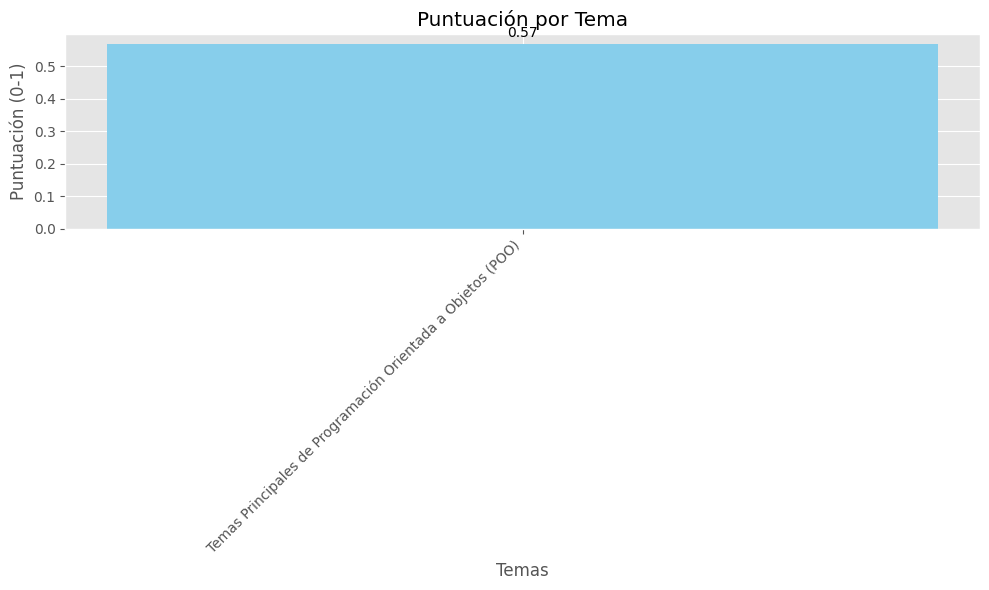

In [4]:
# Ejecutamos la evaluación
print("\nIniciando evaluación completa...")
evaluation_results = evaluate_educational_materials(data)

if evaluation_results:
    # Mostrar resultados resumidos
    print("\n--- RESULTADOS DE LA EVALUACIÓN ---\n")
    
    # Puntuación global
    print(f"Puntuación global del curso: {evaluation_results['overall_evaluation']['course_average']:.2f}/1.00")
    
    # Mostrar resultados por tema
    print("\nResultados por tema:")
    for topic, scores in evaluation_results['overall_evaluation']['topic_scores'].items():
        print(f"  - {topic}: {scores['topic_average_score']:.2f}/1.00")
        print(f"    Consistencia: {scores['consistency_score']:.2f}/1.00")
        
        if 'content_scores' in scores:
            for content_type, metrics in scores['content_scores'].items():
                print(f"    {content_type}: {metrics['overall_score']:.2f}/1.00")
                print(f"      - Relevancia: {metrics['relevance_score']:.2f}")
                print(f"      - Legibilidad: {metrics['readability_score']:.2f}")
                print(f"      - Terminología: {metrics['terminology_score']:.2f}")
    
    # Mostrar palabras clave del dominio detectadas
    print("\nPalabras clave del dominio identificadas:")
    print(", ".join(evaluation_results['domain_keywords'][:10]) + 
          (", ..." if len(evaluation_results['domain_keywords']) > 10 else ""))
    
    # Mostrar recomendaciones si existen
    if evaluation_results['recommendations']:
        print("\nRecomendaciones para mejorar:")
        for topic, rec in evaluation_results['recommendations'].items():
            print(f"  - {topic}:")
            for content_type, recommendations in rec.items():
                print(f"    {content_type}:")
                for r in recommendations:
                    print(f"      * {r}")
    
    # Guardar resultados en archivo JSON
    output_file = 'evaluation_results.json'
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(evaluation_results, f, indent=2, ensure_ascii=False)
        print(f"\nResultados completos guardados en: {output_file}")
    except Exception as e:
        print(f"Error al guardar resultados: {e}")
    
    # Generar visualizaciones
    try:
        # Crear un DataFrame para visualizar puntuaciones generales
        topics = []
        scores = []
        
        for topic, topic_scores in evaluation_results['overall_evaluation']['topic_scores'].items():
            topics.append(topic)
            scores.append(topic_scores['topic_average_score'])
        
        if topics and scores:
            # Gráfico de barras para puntuaciones por tema
            plt.figure(figsize=(10, 6))
            bars = plt.bar(topics, scores, color='skyblue')
            plt.xlabel('Temas')
            plt.ylabel('Puntuación (0-1)')
            plt.title('Puntuación por Tema')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            
            # Añadir etiquetas de valor en las barras
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}', ha='center', va='bottom')
            
            plt.savefig('tema_scores.png')
            print("Gráfico de puntuaciones por tema guardado como: tema_scores.png")
            
            # Heatmap de puntuaciones detalladas
            if len(topics) > 1:  # Solo si hay más de un tema
                # Preparar datos para el heatmap
                heatmap_data = []
                metric_names = ['Relevancia', 'Legibilidad', 'Terminología', 'Consistencia']
                
                for topic in topics:
                    topic_data = evaluation_results['overall_evaluation']['topic_scores'][topic]
                    
                    # Calculamos promedios por métrica para este tema
                    avg_relevance = np.mean([scores['relevance_score'] 
                                          for scores in topic_data['content_scores'].values()])
                    avg_readability = np.mean([scores['readability_score'] 
                                            for scores in topic_data['content_scores'].values()])
                    avg_terminology = np.mean([scores['terminology_score'] 
                                            for scores in topic_data['content_scores'].values()])
                    consistency = topic_data['consistency_score']
                    
                    heatmap_data.append([avg_relevance, avg_readability, avg_terminology, consistency])
                
                # Crear el heatmap
                heatmap_df = pd.DataFrame(heatmap_data, index=topics, columns=metric_names)
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5, vmin=0, vmax=1)
                plt.title('Detalle de Métricas por Tema')
                plt.tight_layout()
                plt.savefig('detalle_metricas.png')
                print("Heatmap de métricas detalladas guardado como: detalle_metricas.png")
        
    except Exception as e:
        print(f"Error al generar visualizaciones: {e}")

else:
    print("No se pudieron evaluar los materiales. Verifica el formato de los datos.")

print("\nProceso de evaluación completado.")

# Para usar interactivamente, puedes acceder a evaluation_results
if 'evaluation_results' in locals():
    print("\nPuedes acceder a los resultados detallados mediante la variable 'evaluation_results'")

# Ejemplo de cómo evaluar un nuevo archivo JSON
def evaluate_new_materials(json_path):
    """
    Función auxiliar para evaluar un nuevo archivo JSON de materiales.
    
    Args:
        json_path (str): Ruta al archivo JSON con nuevos materiales
    
    Returns:
        dict: Resultados de la evaluación
    """
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Validar estructura
        is_valid, error_msg = validate_json_structure(data)
        if not is_valid:
            print(f"Error en la estructura del JSON: {error_msg}")
            return None
        
        # Ejecutar evaluación
        return evaluate_educational_materials(data)
    except Exception as e:
        print(f"Error al evaluar nuevos materiales: {e}")
        return None

In [5]:
# Ejemplo: 
# new_results = evaluate_new_materials('nuevo_material.json')